In [25]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea   # A visualization library offering a high-level interface for creating attractive and informative statistical graphics
import os
from tqdm.notebook import tqdm   ##  A progress bar library, particularly useful in Jupyter notebooks.
import cv2 as op
import torch
from torchsummary import summary
import torchmetrics

plt.style.use('seaborn-v0_8')   # Sets the default plotting style for Matplotlib to seaborn-v0_8
np.__version__

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
import matplotlib.pyplot as plt

# Check available styles , all of them will show ip 
print("Available styles:", plt.style.available)

# Use a different style if 'seaborn' is not available
plt.style.use('ggplot')  # Choose a different style if necessary , ggplot : popular choice among data scientists and analysts


Available styles: ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [27]:
# Define the path to the dataset directory
PATH = 'C:/Users/islam/Downloads/ssd/project 1/archive/dataset'
label2id = {}  # for preparing 
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i
    
id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []
# Loop through each label folder in the dataset
for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))# Append the full path of the image to the filenames list
        outcome.append(label2id[label])# Append the corresponding label ID to the outcome list

# Create a DataFrame to store image file paths and their corresponding labels        
df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)  #  Randomly shuffles the DataFrame rows
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
3891,C:/Users/islam/Downloads/ssd/project 1/archive...,3
1446,C:/Users/islam/Downloads/ssd/project 1/archive...,1
172,C:/Users/islam/Downloads/ssd/project 1/archive...,0
1966,C:/Users/islam/Downloads/ssd/project 1/archive...,1
1573,C:/Users/islam/Downloads/ssd/project 1/archive...,1


C:\Users\islam\AppData\Local\Temp\ipykernel_19064\102011426.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')  # palette Specifies the color palette for the bars


<Axes: xlabel='outcome', ylabel='count'>

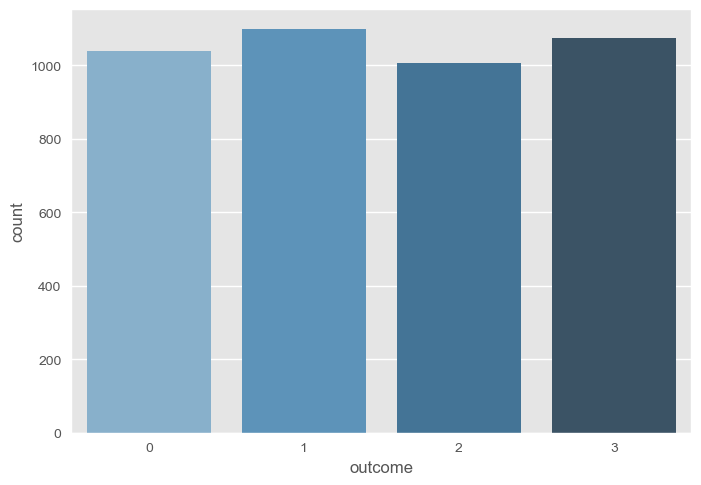

In [28]:
sea.countplot(x = 'outcome', data = df, palette = 'Blues_d')  # palette Specifies the color palette for the bars

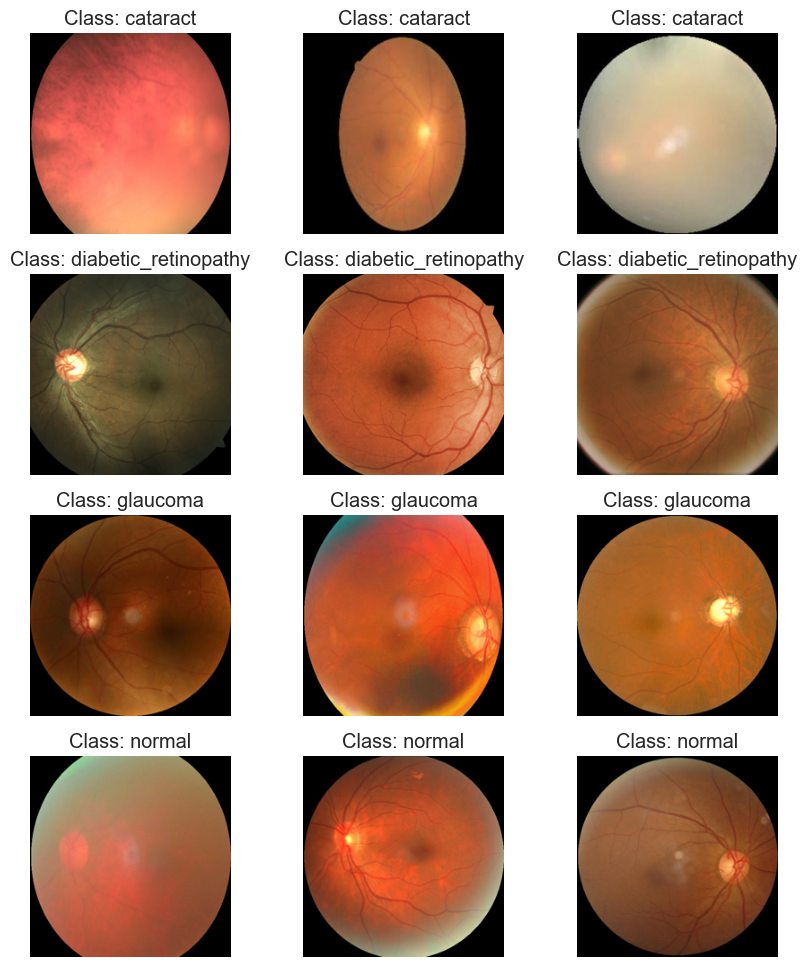

In [29]:

from PIL import Image # For image opening and processing
import os # For file path operations
# i will make change to avoid  non-valid images and add  exception handling to skip any invalid images 
def load_image(img_path):
    try:
        img = Image.open(img_path)
        img = img.convert("RGB")  #  in case it's grayscale
        img = img.resize((224, 224)) # resize the images  
        img = np.array(img) # Convert  to a NumPy array 
        
        # Normalize image to [0, 1]
        img = (img - img.min()) / (img.max() - img.min())  # Min-Max normalization
        
        return img
    except (IOError, ValueError) as e:
        # If the image is invalid, log the error and return None
        print(f"Error loading image {img_path}: {e}")
        return None  # Return None if the image is not valid

counter = 0

plt.figure(figsize = (10, 12))
# Loop through 4 classes and select 3 random images per class
for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 3)['filename']:
        plt.subplot(4, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off') # Remove axes 
        plt.title('Class:' + " " + id2label[i])
        counter += 1
   # Display the grid of images     
plt.show()

# Building the dataset

1. The dataset was building using `torch.utils.data.Dataset` for efficinet loading of data.
2. For data augmentation, only Random Horizontal and Vertical flip was used. Adding augmentaitons in colors, brightness etc made training difficult, since then 

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F
from PIL import Image

# Training transformations
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5), # Flip images horizontally with 50% probability
    transforms.RandomVerticalFlip(p=0.5), # Flip images vertically with 50% probability
    transforms.RandomRotation(30),  # Random rotation ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentations
    transforms.ToTensor()  # Convert to tensor
])

# Validation transformations
val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)), # Resize images to 224x224
    transforms.ToTensor()  # Convert to tensor
])

class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform=None):
         """
        Initialize the dataset.

        Args:
            df (DataFrame): Pandas DataFrame containing image paths and labels.
            n_classes (int): Number of classes in the dataset.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
         """
        Returns the number of samples in the dataset.
        """
        return self.n_samples

    def __getitem__(self, index):
         """
        Retrieve a single sample from the dataset.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple: A tuple containing the image tensor and its corresponding label.
        """
        image_path = self.df.iloc[index, 0]
        label = self.df.iloc[index, 1]
        
        try:
            # Open image and ensure it's in RGB mode
            img = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Placeholder blank image (can be adjusted)
            img = Image.new('RGB', (224, 224))
            label = -1  # Indicate an error in label

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        return img.to(torch.float32), label # Convert image to float32


#1. 85% of the dataset was used for training while the remaining for validation/testing.
#2. Batch Size of 128 was chosen.

In [31]:
from sklearn.model_selection import train_test_split
 # Splitting the DataFrame into training and validation sets ,15% of the data is allocated to the validation set, and the rest is for training
df_train, df_val = train_test_split(df, test_size = 0.15, random_state = 28)

df_train.shape, df_val.shape

((3795, 2), (422, 2))

In [32]:
NUM_CLASSES = 4 # Number of distinct classes
BATCH_SIZE = 128 # Number of samples per batch  

# Create training and validation datasets using the EyeDataset class
train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)

# Create data loaders for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [33]:
# Get the first batch of images and labels from the training DataLoader
a, b = next(iter(train_loader))

print(a.shape, b.shape)

# Free up memory by deleting the tensors
del(a)
del(b)

torch.Size([128, 3, 224, 224]) torch.Size([128])


# Model Architecture

1. We used the Resnet18 pretrained model for this task.

2. ResNet-18 is composed of multiple residual blocks, which are designed to address the problem of vanishing gradients in deep neural networks. These blocks introduce skip connections, allowing information to bypass several layers and flow directly to deeper layers. This helps in mitigating the degradation problem and enables the network to learn more effectively, even with very deep architectures.

3. We replaced the final layer with two new dense layer. 70% of the resnet18 was freezed while the remaining was kept trianable. The resnet18 block was trained with a lr of 5x10 <sup>-5</sup> while the dense layers with lr = 8x10<sup>-4</sup>. 

![resnet18](https://i.imgur.com/XwcnU5x.png)

In [34]:
from math import ceil

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = torchvision.models.resnet18(pretrained = True)
        # Freeze layers in the base model except the last 15 layers
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
         # Define the custom classifier block  
        self.block = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),# Output layer for 4 classes
        )
         # Disable the original classifier and fully connected layer in ResNet
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
        
        
    def get_optimizer(self):
        return torch.optim.AdamW([
            # Optimizer for both the frozen ResNet layers and the custom block
            {'params' : self.base.parameters(), 'lr': 3e-5},
            {'params' : self.block.parameters(), 'lr': 8e-4}
        ])
        
        
    def forward(self, x):
        x = self.base(x)
        x = self.block(x)
        return x
            

class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader= val_loader
        self.device = device
        
        self.model = Net().to(self.device) #  move model to the device
        self.optimizer = self.model.get_optimizer() # Get the optimizer for model parameters
        self.loss_fxn = nn.CrossEntropyLoss() # Loss function for multiclass classification
        self.accuracy = torchmetrics.Accuracy(task = "multiclass", num_classes = NUM_CLASSES).to(self.device) # Accuracy metric
               
        # History dictionary to store training and validation metrics for each epoch
        self.history = {'train_loss' : [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    def training_step(self, x, y):
        pred = self.model(x) # Model predictions
        loss = self.loss_fxn(pred, y)  # Compute loss
        acc = self.accuracy(pred, y) # Compute accuracy
        
        self.optimizer.zero_grad() # Zero the gradients from previous step
        loss.backward() # Backpropagate the loss
        self.optimizer.step() # Update the model parameters
        
        return loss, acc
    
    def val_step(self, x, y):
        with torch.no_grad(): # No gradient calculation required for validation
            pred = self.model(x)
            loss = self.loss_fxn(pred, y)
            acc = self.accuracy(pred, y)
            
        return loss, acc
    
    def step_fxn(self, loader, step):
        loss, acc = 0, 0
        
        for X, y in tqdm(loader):
            X, y = X.to(self.device), y.to(self.device) # Move data to the device
            l, a = step(X, y) # Call the corresponding step function (training or validation)
            loss, acc = loss + l.item(), acc + a.item() # Accumulate loss and accuracy
            
        return loss/len(loader), acc/len(loader)  # Return average loss and accuracy
    
    def train(self, epochs):
        # Perform training and validation steps
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_acc = self.step_fxn(self.train_loader, self.training_step)
            val_loss, val_acc = self.step_fxn(self.val_loader, self.val_step)
            
            # Store the metrics in the history dictionary
            for item, value in zip(self.history.keys(), list([train_loss, val_loss, train_acc, val_acc])):
                self.history[item].append(value)
            
            # Print the metrics for the current epoch
            print("[Epoch: {}] Train: [loss: {:.3f} acc: {:.3f}] Val: [loss: {:.3f} acc:{:.3f}]".format(epoch + 1, train_loss, train_acc, val_loss, val_acc))
    

In [35]:
trainer = Trainer(train_loader, val_loader, device) # Initialize the Trainer object

C:\Users\islam\anaconda3\envs\ssd\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\islam\anaconda3\envs\ssd\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [36]:
summary(trainer.model.base, (3, 224, 224)) # provides a detailed layer-by-layer description of the model

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

In [37]:
trainer.train(epochs = 8) # start training  model for 8 epochs

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 1] Train: [loss: 0.857 acc: 0.652] Val: [loss: 0.544 acc:0.793]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 2] Train: [loss: 0.524 acc: 0.795] Val: [loss: 0.371 acc:0.875]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 3] Train: [loss: 0.431 acc: 0.834] Val: [loss: 0.336 acc:0.880]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 4] Train: [loss: 0.376 acc: 0.856] Val: [loss: 0.295 acc:0.896]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 5] Train: [loss: 0.340 acc: 0.866] Val: [loss: 0.334 acc:0.867]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 6] Train: [loss: 0.299 acc: 0.886] Val: [loss: 0.287 acc:0.889]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 7] Train: [loss: 0.303 acc: 0.884] Val: [loss: 0.275 acc:0.894]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[Epoch: 8] Train: [loss: 0.277 acc: 0.885] Val: [loss: 0.293 acc:0.890]


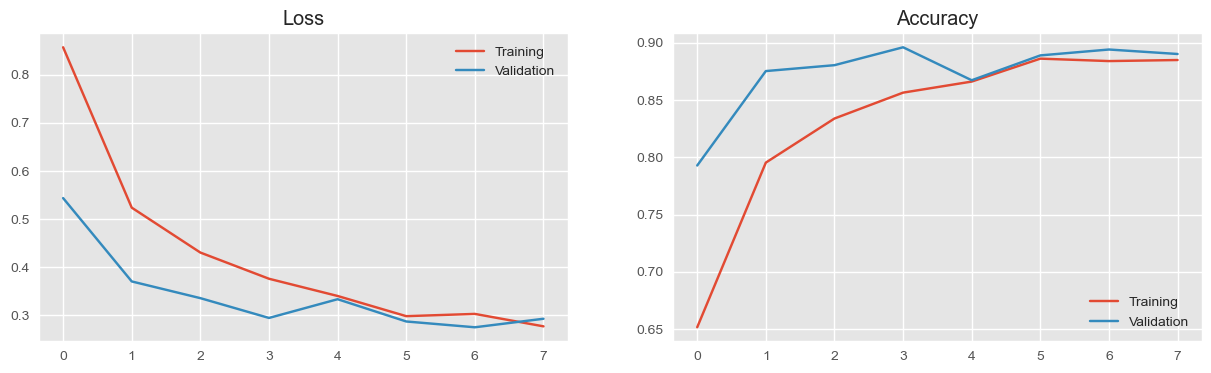

In [38]:
# Plot training and validation loss
plt.figure(figsize = (15, 4))

# Plot loss
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(trainer.history['train_loss'], label = 'Training')
plt.plot(trainer.history['val_loss'], label = 'Validation')
plt.legend()


# Plot accuracy
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(trainer.history['train_acc'], label = 'Training')
plt.plot(trainer.history['val_acc'], label = 'Validation')
plt.legend()



In [39]:
preds, true = [], []

# Disable gradient calculation for inference
with torch.no_grad():
    for x, y in tqdm(val_loader):
                # Perform inference and get the predicted class

        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        # Append the predictions and true labels to the lists
        preds.extend(pred)
        true.extend(y)
        
len(preds), len(true)

  0%|          | 0/4 [00:00<?, ?it/s]

(422, 422)

Text(0.5, 1.0, 'Confusion Matrix')

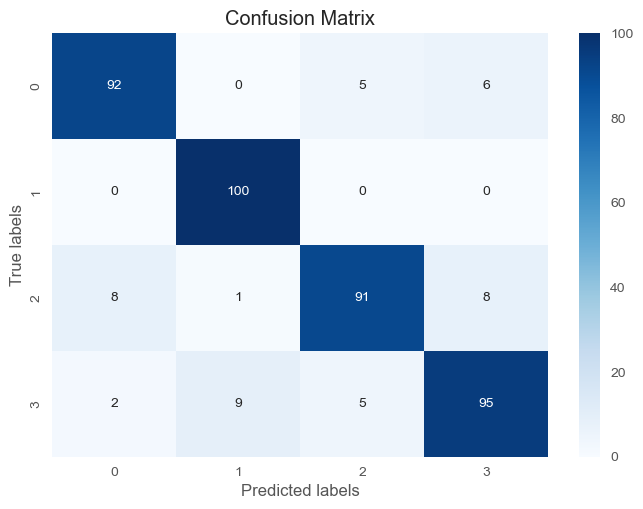

In [40]:
from sklearn.metrics import confusion_matrix
# Generate the confusion matrix
cm = confusion_matrix(true, preds)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

In [41]:
from sklearn.metrics import classification_report
# Print the classification report
print(classification_report(true, preds, target_names = label2id.keys()))

                      precision    recall  f1-score   support

            cataract       0.90      0.89      0.90       103
diabetic_retinopathy       0.91      1.00      0.95       100
            glaucoma       0.90      0.84      0.87       108
              normal       0.87      0.86      0.86       111

            accuracy                           0.90       422
           macro avg       0.90      0.90      0.90       422
        weighted avg       0.90      0.90      0.89       422



In [42]:
torch.save(trainer.model.state_dict(), 'eye_disease_classifier00.pth')


In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
# Load the saved model
def load_trained_model(model_path='eye_disease_classifier.pth', device='cpu'):
    model = Net().to(device)
     # Load the model's state dict (weights) from the specified file
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode
    return model

    

In [ ]:
# Image preprocessing for prediction
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)), # Resize the image to 224x224
        transforms.ToTensor() # Convert to tensor
        
    ])
    img = Image.open(img_path).convert('RGB')
    
    img = transform(img).unsqueeze(0)  # Apply the transformations and add an additional batch dimension
    return img


In [ ]:
# Predict the class of the image
def classify_image(model, img_path, device='cpu', id2label=None):
    img = preprocess_image(img_path).to(device)
    
    with torch.no_grad():
        output = model(img)  # Get model predictions
        _, predicted_class = torch.max(output, 1)  # Get the predicted class index
        
    predicted_label = id2label[predicted_class.item()]  # Convert index to label
    return predicted_label



In [ ]:
# Display the image with the prediction and real label

def display_image_with_prediction(img_path, real_label, predicted_label):
    img = Image.open(img_path)
    
    # Check if the real label matches the predicted label
    title_color = 'green' if real_label == predicted_label else 'red'
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Real: {real_label}, Predicted: {predicted_label}", color=title_color)
    plt.show()

    

In [ ]:
# Function that ties everything together: load model, classify image, and display the result
def test_multiple_images(dataset, model_path='eye_disease_classifier.pth', device='cpu', id2label=None, num_images=5):
    # Load the trained model
    model = load_trained_model(model_path, device)
    
    # Randomly sample a number of images from the dataset
    sampled_data = random.sample(dataset, num_images)
    
    for img_path, real_label in sampled_data:
        # Classify the image
        predicted_label = classify_image(model, img_path, device, id2label)
        
        # Display the image with the real and predicted label
        display_image_with_prediction(img_path, real_label, predicted_label)


In [ ]:
dataset = [(os.path.join('DataSet/Eye Disease', label, img), label) for label in os.listdir('DataSet/Eye Disease') for img in os.listdir(os.path.join('DataSet/Eye Disease', label))]

# Test multiple images from the dataset
test_multiple_images(dataset, model_path='eye_disease_classifier.pth', device='cuda', id2label=id2label, num_images=10)